# Visualization of changes by speckle variability using Sentinel-1 data

### **R**apid and **EA**sy **C**hange detection in radar **TI**me-series by **V**ariation coefficient

![REACTIV logo](https://raw.githubusercontent.com/elisekoeniguer/REACTIV/master/REACTIV.png)  

##### Display a stack of SAR images with change detection highlighting

<i>Colored visualization of multitemporal data for change detection: issues and methods</i>, Elise Colin Koeniguer et al., EUSAR 2018  
[github link](https://github.com/elisekoeniguer/REACTIV)

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np

from scipy.special import gamma
from skimage import color

from eolearn.io import S1IWWCSInput
from eolearn.core import EOTask, EOPatch, FeatureType, LinearWorkflow

from sentinelhub import BBox, CRS

In [2]:
def speckle_variability(data, mask, timestamps):
    data_shape = data.shape[1:3]

    time_delta = np.max(timestamps) - np.min(timestamps)
    min_time = np.min(timestamps)
    time = (np.array(timestamps) - min_time) / time_delta

    masked_data = np.ma.array(data.squeeze(), mask=np.logical_not(mask.squeeze()))

    mb1 = masked_data.mean(axis=0)
    mb2 = np.ma.power(masked_data, 2).mean(axis=0)
    kmax = time[masked_data.argmax(axis=0).ravel()].reshape(data_shape).astype(np.float32)
    imax = data.squeeze().max(axis=0)

    R = np.sqrt(mb2 - mb1 ** 2) / mb1

    gam = R.mean()
    a = 0.991936 + 0.067646 * gam - 0.098888 * gam ** 2 - 0.048320 * gam ** 3
    b = 0.001224 - 0.034323 * gam + 4.305577 * gam ** 2 - 1.163498 * gam ** 3
    L = a / b

    CV = np.sqrt((L * gamma(L) ** 2 / (gamma(L + 0.5) ** 2)) - 1)  # theoretical mean value
    num = (L * gamma(L) ** 4 * (4 * (L ** 2) * gamma(L) ** 2 - 4 * L * gamma(L + 0.5) ** 2 - gamma(L + 0.5) ** 2))
    den = (gamma(L + 0.5) ** 4 * (L * gamma(L) ** 2 - gamma(L + 0.5) ** 2))
    alpha = 0.25 * num / den  # theoretical standard deviation value

    R = (R - CV) / (alpha / np.sqrt(np.count_nonzero(data, axis=0).squeeze())) / 10.0 + 0.25
    R = np.clip(R.data, a_min=0, a_max=1)  # Cast Coefficient of Varation R max to 1

    threshold = np.mean(masked_data[0]) + 15 * np.std(masked_data[0])
    I = np.clip(imax / threshold, a_max=1, a_min=0)  # normalize Intensity to threshold

    hsv = np.stack([kmax, R.data, I], axis=2).astype(np.float32)

    return hsv

## Practice

The above method seems suitable to be put into an `EOTask`. Let's make one!

<div class="alert alert-success">
 <b>EXERCISE</b>:


* Create an [EOTask](eolearn_basics.ipynb#EOTask) from the `speckle_variability` method. Think if the resulting data is temporal or timeless (in terms of `FeatureType`). 
* Run the task on `data/sentinel1_sample` and produce an image.
* Try to combine lessons learned in **Sentinel-Hub and other datasources** section, download Sentinel-1 data for year 2018 over given coordinates, at '120m' resolution and then run the task to produce an image. Do you recognize what is going on (and where)?
 
</div>

<br/><br/>
EOTask wrapping the `speckle_variability` method

In [3]:
# %load ../solutions/sentinel1_task.py

<br/><br/>
Produce an image using above EOTask

In [4]:
EOPATCH_PATH = '../data/sentinel1_sample/'

def plot_results(hsv):
    """ A function for plotting results
    """
    plt.figure(figsize=(15, 15))
    plt.imshow(color.hsv2rgb(hsv));

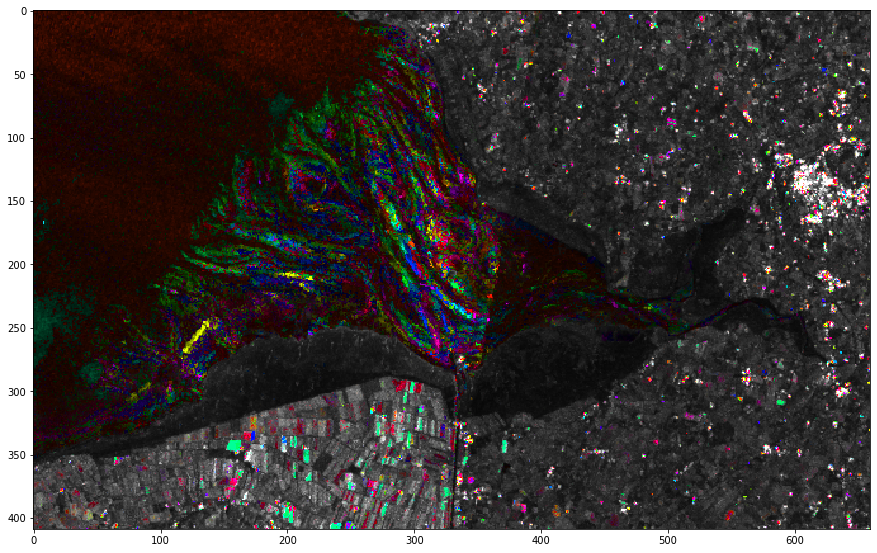

In [5]:
# %load ../solutions/sentinel1_image.py

<br/><br/>
Download S1 data, run task, produce image

In [6]:
bbox = BBox([-5.996475, 35.706378, -5.285797, 36.157836], crs=CRS.WGS84)
time_interval = ('2018-01-01', '2018-12-31')

In [ ]:
# %load ../solutions/sentinel1_pipeline.py